In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.3.0+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os.path as osp
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

In [4]:
use_cuda=False

In [5]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset.get(0)

Processing...
Done!


In [6]:
num_nodes = data.x.shape[0]

In [7]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

In [8]:
class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [9]:
#Discriminator Class
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [10]:
#training algorithm
def train():
    model.train()
    encoder_optimizer.zero_grad()

    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        idx = range(num_nodes)
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z[idx]) # Comment
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()

    loss = 0
    loss = loss + model.reg_loss(z)  # Comment

    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()

    encoder_optimizer.step()

    return loss

In [11]:
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi

In [12]:
latent_size = 32
encoder = VEncoder(data.num_features, out_channels=latent_size)

discriminator = Discriminator(in_channels=latent_size, hidden_channels=64,
                              out_channels=1) # Comment

In [13]:
model = ARGVA(encoder, discriminator)

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
model, data = model.to(device), data.to(device)

In [14]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

In [15]:
for epoch in range(1, 201):
    loss = train()
    auc, ap, completeness, hm, nmi = test()
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
           f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 001, Loss: 5.495, AUC: 0.731, AP: 0.740, Completeness: 0.051, Homogeneity: 0.051, NMI: 0.051


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 002, Loss: 4.953, AUC: 0.714, AP: 0.732, Completeness: 0.051, Homogeneity: 0.050, NMI: 0.050


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 003, Loss: 4.544, AUC: 0.706, AP: 0.729, Completeness: 0.052, Homogeneity: 0.050, NMI: 0.051


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 004, Loss: 4.167, AUC: 0.708, AP: 0.731, Completeness: 0.054, Homogeneity: 0.052, NMI: 0.053


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 005, Loss: 3.681, AUC: 0.718, AP: 0.739, Completeness: 0.083, Homogeneity: 0.080, NMI: 0.082


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 006, Loss: 3.317, AUC: 0.739, AP: 0.758, Completeness: 0.097, Homogeneity: 0.096, NMI: 0.096


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 007, Loss: 2.934, AUC: 0.765, AP: 0.783, Completeness: 0.169, Homogeneity: 0.167, NMI: 0.168


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 008, Loss: 2.667, AUC: 0.761, AP: 0.782, Completeness: 0.187, Homogeneity: 0.183, NMI: 0.185


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 009, Loss: 2.441, AUC: 0.733, AP: 0.755, Completeness: 0.186, Homogeneity: 0.181, NMI: 0.183


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 010, Loss: 2.352, AUC: 0.725, AP: 0.747, Completeness: 0.209, Homogeneity: 0.207, NMI: 0.208


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 011, Loss: 2.280, AUC: 0.738, AP: 0.757, Completeness: 0.242, Homogeneity: 0.243, NMI: 0.242


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 012, Loss: 2.218, AUC: 0.761, AP: 0.778, Completeness: 0.263, Homogeneity: 0.264, NMI: 0.263


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 013, Loss: 2.198, AUC: 0.772, AP: 0.787, Completeness: 0.285, Homogeneity: 0.276, NMI: 0.280


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 014, Loss: 2.188, AUC: 0.770, AP: 0.784, Completeness: 0.293, Homogeneity: 0.284, NMI: 0.288


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 015, Loss: 2.254, AUC: 0.773, AP: 0.787, Completeness: 0.308, Homogeneity: 0.295, NMI: 0.301


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 016, Loss: 2.308, AUC: 0.784, AP: 0.798, Completeness: 0.325, Homogeneity: 0.311, NMI: 0.318


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 017, Loss: 2.322, AUC: 0.801, AP: 0.814, Completeness: 0.344, Homogeneity: 0.329, NMI: 0.337


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 018, Loss: 2.327, AUC: 0.813, AP: 0.826, Completeness: 0.354, Homogeneity: 0.354, NMI: 0.354


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 019, Loss: 2.354, AUC: 0.817, AP: 0.830, Completeness: 0.343, Homogeneity: 0.349, NMI: 0.346


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 020, Loss: 2.436, AUC: 0.820, AP: 0.831, Completeness: 0.351, Homogeneity: 0.356, NMI: 0.353


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 021, Loss: 2.513, AUC: 0.828, AP: 0.835, Completeness: 0.359, Homogeneity: 0.363, NMI: 0.361


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 022, Loss: 2.586, AUC: 0.844, AP: 0.848, Completeness: 0.374, Homogeneity: 0.378, NMI: 0.376


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 023, Loss: 2.640, AUC: 0.859, AP: 0.862, Completeness: 0.378, Homogeneity: 0.382, NMI: 0.380


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 024, Loss: 2.687, AUC: 0.861, AP: 0.866, Completeness: 0.382, Homogeneity: 0.387, NMI: 0.384


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 025, Loss: 2.768, AUC: 0.853, AP: 0.859, Completeness: 0.384, Homogeneity: 0.390, NMI: 0.387


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 026, Loss: 2.910, AUC: 0.847, AP: 0.853, Completeness: 0.427, Homogeneity: 0.432, NMI: 0.429


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 027, Loss: 3.028, AUC: 0.850, AP: 0.854, Completeness: 0.431, Homogeneity: 0.436, NMI: 0.434


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 028, Loss: 3.085, AUC: 0.858, AP: 0.859, Completeness: 0.443, Homogeneity: 0.450, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 029, Loss: 3.057, AUC: 0.865, AP: 0.863, Completeness: 0.450, Homogeneity: 0.457, NMI: 0.453


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 030, Loss: 3.039, AUC: 0.868, AP: 0.862, Completeness: 0.437, Homogeneity: 0.445, NMI: 0.441


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 031, Loss: 3.085, AUC: 0.868, AP: 0.860, Completeness: 0.427, Homogeneity: 0.431, NMI: 0.429


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 032, Loss: 3.191, AUC: 0.868, AP: 0.860, Completeness: 0.426, Homogeneity: 0.432, NMI: 0.429


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 033, Loss: 3.347, AUC: 0.869, AP: 0.863, Completeness: 0.428, Homogeneity: 0.432, NMI: 0.430


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 034, Loss: 3.509, AUC: 0.870, AP: 0.865, Completeness: 0.428, Homogeneity: 0.434, NMI: 0.431


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 035, Loss: 3.665, AUC: 0.869, AP: 0.866, Completeness: 0.426, Homogeneity: 0.433, NMI: 0.429


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 036, Loss: 3.786, AUC: 0.865, AP: 0.864, Completeness: 0.424, Homogeneity: 0.431, NMI: 0.427


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 037, Loss: 3.923, AUC: 0.863, AP: 0.863, Completeness: 0.424, Homogeneity: 0.434, NMI: 0.429


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 038, Loss: 4.070, AUC: 0.863, AP: 0.865, Completeness: 0.418, Homogeneity: 0.431, NMI: 0.425


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 039, Loss: 4.172, AUC: 0.869, AP: 0.870, Completeness: 0.429, Homogeneity: 0.442, NMI: 0.436


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 040, Loss: 4.124, AUC: 0.876, AP: 0.877, Completeness: 0.412, Homogeneity: 0.416, NMI: 0.414


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 041, Loss: 4.199, AUC: 0.883, AP: 0.883, Completeness: 0.391, Homogeneity: 0.392, NMI: 0.392


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 042, Loss: 4.207, AUC: 0.886, AP: 0.886, Completeness: 0.400, Homogeneity: 0.397, NMI: 0.398


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 043, Loss: 4.248, AUC: 0.885, AP: 0.883, Completeness: 0.402, Homogeneity: 0.398, NMI: 0.400


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 044, Loss: 4.295, AUC: 0.879, AP: 0.876, Completeness: 0.409, Homogeneity: 0.404, NMI: 0.407


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 045, Loss: 4.347, AUC: 0.874, AP: 0.869, Completeness: 0.411, Homogeneity: 0.404, NMI: 0.408


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 046, Loss: 4.416, AUC: 0.869, AP: 0.863, Completeness: 0.397, Homogeneity: 0.392, NMI: 0.395


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 047, Loss: 4.523, AUC: 0.863, AP: 0.857, Completeness: 0.401, Homogeneity: 0.394, NMI: 0.397


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 048, Loss: 4.462, AUC: 0.856, AP: 0.851, Completeness: 0.405, Homogeneity: 0.398, NMI: 0.401


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 049, Loss: 4.420, AUC: 0.852, AP: 0.848, Completeness: 0.404, Homogeneity: 0.397, NMI: 0.401


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 050, Loss: 4.386, AUC: 0.851, AP: 0.846, Completeness: 0.405, Homogeneity: 0.403, NMI: 0.404


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 051, Loss: 4.222, AUC: 0.853, AP: 0.848, Completeness: 0.411, Homogeneity: 0.412, NMI: 0.412


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 052, Loss: 4.324, AUC: 0.856, AP: 0.851, Completeness: 0.409, Homogeneity: 0.411, NMI: 0.410


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 053, Loss: 4.197, AUC: 0.861, AP: 0.855, Completeness: 0.412, Homogeneity: 0.414, NMI: 0.413


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 054, Loss: 4.140, AUC: 0.864, AP: 0.857, Completeness: 0.411, Homogeneity: 0.414, NMI: 0.412


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 055, Loss: 4.098, AUC: 0.865, AP: 0.857, Completeness: 0.409, Homogeneity: 0.413, NMI: 0.411


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 056, Loss: 3.945, AUC: 0.866, AP: 0.857, Completeness: 0.431, Homogeneity: 0.429, NMI: 0.430


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 057, Loss: 3.992, AUC: 0.870, AP: 0.859, Completeness: 0.432, Homogeneity: 0.430, NMI: 0.431


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 058, Loss: 4.013, AUC: 0.876, AP: 0.865, Completeness: 0.434, Homogeneity: 0.433, NMI: 0.433


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 059, Loss: 3.856, AUC: 0.880, AP: 0.869, Completeness: 0.438, Homogeneity: 0.439, NMI: 0.438


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 060, Loss: 3.860, AUC: 0.883, AP: 0.872, Completeness: 0.439, Homogeneity: 0.441, NMI: 0.440


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 061, Loss: 3.833, AUC: 0.885, AP: 0.874, Completeness: 0.440, Homogeneity: 0.442, NMI: 0.441


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 062, Loss: 3.815, AUC: 0.887, AP: 0.876, Completeness: 0.440, Homogeneity: 0.443, NMI: 0.442


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 063, Loss: 3.880, AUC: 0.888, AP: 0.877, Completeness: 0.447, Homogeneity: 0.451, NMI: 0.449


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 064, Loss: 3.874, AUC: 0.889, AP: 0.879, Completeness: 0.448, Homogeneity: 0.452, NMI: 0.450


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 065, Loss: 3.905, AUC: 0.890, AP: 0.880, Completeness: 0.439, Homogeneity: 0.449, NMI: 0.444


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 066, Loss: 3.955, AUC: 0.891, AP: 0.881, Completeness: 0.435, Homogeneity: 0.446, NMI: 0.440


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 067, Loss: 3.949, AUC: 0.892, AP: 0.883, Completeness: 0.437, Homogeneity: 0.430, NMI: 0.434


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 068, Loss: 3.981, AUC: 0.892, AP: 0.884, Completeness: 0.438, Homogeneity: 0.430, NMI: 0.434


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 069, Loss: 3.999, AUC: 0.893, AP: 0.884, Completeness: 0.440, Homogeneity: 0.449, NMI: 0.444


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 070, Loss: 4.040, AUC: 0.893, AP: 0.885, Completeness: 0.439, Homogeneity: 0.449, NMI: 0.444


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 071, Loss: 4.061, AUC: 0.894, AP: 0.885, Completeness: 0.444, Homogeneity: 0.453, NMI: 0.449


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 072, Loss: 4.158, AUC: 0.895, AP: 0.887, Completeness: 0.441, Homogeneity: 0.449, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 073, Loss: 4.183, AUC: 0.896, AP: 0.888, Completeness: 0.442, Homogeneity: 0.450, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 074, Loss: 4.121, AUC: 0.897, AP: 0.889, Completeness: 0.442, Homogeneity: 0.422, NMI: 0.431


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 075, Loss: 4.191, AUC: 0.898, AP: 0.890, Completeness: 0.443, Homogeneity: 0.423, NMI: 0.433


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 076, Loss: 4.152, AUC: 0.899, AP: 0.892, Completeness: 0.443, Homogeneity: 0.451, NMI: 0.447


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 077, Loss: 4.143, AUC: 0.900, AP: 0.893, Completeness: 0.445, Homogeneity: 0.424, NMI: 0.434


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 078, Loss: 4.134, AUC: 0.901, AP: 0.894, Completeness: 0.441, Homogeneity: 0.451, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 079, Loss: 4.149, AUC: 0.902, AP: 0.894, Completeness: 0.434, Homogeneity: 0.441, NMI: 0.438


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 080, Loss: 4.099, AUC: 0.903, AP: 0.896, Completeness: 0.433, Homogeneity: 0.442, NMI: 0.438


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 081, Loss: 4.144, AUC: 0.904, AP: 0.897, Completeness: 0.445, Homogeneity: 0.426, NMI: 0.436


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 082, Loss: 4.034, AUC: 0.905, AP: 0.899, Completeness: 0.441, Homogeneity: 0.451, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 083, Loss: 4.130, AUC: 0.906, AP: 0.900, Completeness: 0.452, Homogeneity: 0.435, NMI: 0.444


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 084, Loss: 4.054, AUC: 0.908, AP: 0.903, Completeness: 0.452, Homogeneity: 0.435, NMI: 0.443


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 085, Loss: 4.218, AUC: 0.910, AP: 0.905, Completeness: 0.459, Homogeneity: 0.443, NMI: 0.450


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 086, Loss: 3.999, AUC: 0.911, AP: 0.907, Completeness: 0.446, Homogeneity: 0.441, NMI: 0.443


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 087, Loss: 4.032, AUC: 0.912, AP: 0.908, Completeness: 0.465, Homogeneity: 0.459, NMI: 0.462


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 088, Loss: 4.009, AUC: 0.914, AP: 0.910, Completeness: 0.468, Homogeneity: 0.454, NMI: 0.461


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 089, Loss: 4.013, AUC: 0.915, AP: 0.911, Completeness: 0.468, Homogeneity: 0.454, NMI: 0.461


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 090, Loss: 4.019, AUC: 0.916, AP: 0.912, Completeness: 0.472, Homogeneity: 0.466, NMI: 0.469


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 091, Loss: 3.926, AUC: 0.916, AP: 0.913, Completeness: 0.472, Homogeneity: 0.458, NMI: 0.465


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 092, Loss: 3.946, AUC: 0.917, AP: 0.915, Completeness: 0.456, Homogeneity: 0.451, NMI: 0.454


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 093, Loss: 3.887, AUC: 0.917, AP: 0.916, Completeness: 0.471, Homogeneity: 0.465, NMI: 0.468


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 094, Loss: 3.945, AUC: 0.918, AP: 0.916, Completeness: 0.466, Homogeneity: 0.460, NMI: 0.463


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 095, Loss: 3.978, AUC: 0.918, AP: 0.916, Completeness: 0.467, Homogeneity: 0.460, NMI: 0.463


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 096, Loss: 3.935, AUC: 0.918, AP: 0.917, Completeness: 0.505, Homogeneity: 0.466, NMI: 0.485


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 097, Loss: 3.951, AUC: 0.919, AP: 0.917, Completeness: 0.502, Homogeneity: 0.468, NMI: 0.484


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 098, Loss: 4.021, AUC: 0.919, AP: 0.917, Completeness: 0.501, Homogeneity: 0.461, NMI: 0.480


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 099, Loss: 3.911, AUC: 0.919, AP: 0.918, Completeness: 0.448, Homogeneity: 0.445, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 100, Loss: 3.902, AUC: 0.920, AP: 0.919, Completeness: 0.448, Homogeneity: 0.445, NMI: 0.447


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 101, Loss: 3.907, AUC: 0.920, AP: 0.919, Completeness: 0.506, Homogeneity: 0.470, NMI: 0.487


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 102, Loss: 3.891, AUC: 0.921, AP: 0.920, Completeness: 0.450, Homogeneity: 0.448, NMI: 0.449


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 103, Loss: 3.852, AUC: 0.921, AP: 0.920, Completeness: 0.511, Homogeneity: 0.474, NMI: 0.492


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 104, Loss: 3.855, AUC: 0.921, AP: 0.921, Completeness: 0.498, Homogeneity: 0.464, NMI: 0.480


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 105, Loss: 3.874, AUC: 0.921, AP: 0.921, Completeness: 0.500, Homogeneity: 0.465, NMI: 0.482


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 106, Loss: 3.893, AUC: 0.921, AP: 0.921, Completeness: 0.500, Homogeneity: 0.496, NMI: 0.498


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 107, Loss: 3.752, AUC: 0.920, AP: 0.922, Completeness: 0.464, Homogeneity: 0.460, NMI: 0.462


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 108, Loss: 3.797, AUC: 0.920, AP: 0.921, Completeness: 0.505, Homogeneity: 0.501, NMI: 0.503


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 109, Loss: 3.718, AUC: 0.920, AP: 0.921, Completeness: 0.507, Homogeneity: 0.505, NMI: 0.506


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 110, Loss: 3.775, AUC: 0.920, AP: 0.921, Completeness: 0.506, Homogeneity: 0.505, NMI: 0.506


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 111, Loss: 3.710, AUC: 0.921, AP: 0.922, Completeness: 0.505, Homogeneity: 0.505, NMI: 0.505


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 112, Loss: 3.685, AUC: 0.921, AP: 0.923, Completeness: 0.501, Homogeneity: 0.504, NMI: 0.503


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 113, Loss: 3.744, AUC: 0.921, AP: 0.923, Completeness: 0.495, Homogeneity: 0.495, NMI: 0.495


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 114, Loss: 3.792, AUC: 0.921, AP: 0.923, Completeness: 0.493, Homogeneity: 0.493, NMI: 0.493


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 115, Loss: 3.821, AUC: 0.921, AP: 0.923, Completeness: 0.496, Homogeneity: 0.501, NMI: 0.499


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 116, Loss: 3.766, AUC: 0.921, AP: 0.923, Completeness: 0.490, Homogeneity: 0.492, NMI: 0.491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 117, Loss: 3.801, AUC: 0.921, AP: 0.923, Completeness: 0.493, Homogeneity: 0.495, NMI: 0.494


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 118, Loss: 3.842, AUC: 0.921, AP: 0.923, Completeness: 0.491, Homogeneity: 0.492, NMI: 0.492


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 119, Loss: 3.782, AUC: 0.921, AP: 0.923, Completeness: 0.493, Homogeneity: 0.497, NMI: 0.495


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 120, Loss: 3.772, AUC: 0.921, AP: 0.923, Completeness: 0.490, Homogeneity: 0.491, NMI: 0.491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 121, Loss: 3.824, AUC: 0.920, AP: 0.923, Completeness: 0.494, Homogeneity: 0.488, NMI: 0.491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 122, Loss: 3.824, AUC: 0.920, AP: 0.922, Completeness: 0.492, Homogeneity: 0.485, NMI: 0.489


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 123, Loss: 3.795, AUC: 0.919, AP: 0.922, Completeness: 0.492, Homogeneity: 0.485, NMI: 0.489


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 124, Loss: 3.774, AUC: 0.919, AP: 0.922, Completeness: 0.490, Homogeneity: 0.483, NMI: 0.486


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 125, Loss: 3.770, AUC: 0.919, AP: 0.922, Completeness: 0.490, Homogeneity: 0.482, NMI: 0.486


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 126, Loss: 3.791, AUC: 0.919, AP: 0.922, Completeness: 0.494, Homogeneity: 0.486, NMI: 0.490


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 127, Loss: 3.810, AUC: 0.919, AP: 0.922, Completeness: 0.492, Homogeneity: 0.483, NMI: 0.488


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 128, Loss: 3.758, AUC: 0.919, AP: 0.922, Completeness: 0.476, Homogeneity: 0.468, NMI: 0.472


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 129, Loss: 3.792, AUC: 0.919, AP: 0.922, Completeness: 0.487, Homogeneity: 0.479, NMI: 0.483


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 130, Loss: 3.795, AUC: 0.918, AP: 0.922, Completeness: 0.445, Homogeneity: 0.437, NMI: 0.441


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 131, Loss: 3.762, AUC: 0.918, AP: 0.923, Completeness: 0.488, Homogeneity: 0.481, NMI: 0.484


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 132, Loss: 3.722, AUC: 0.920, AP: 0.924, Completeness: 0.471, Homogeneity: 0.470, NMI: 0.471


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 133, Loss: 3.784, AUC: 0.921, AP: 0.926, Completeness: 0.444, Homogeneity: 0.438, NMI: 0.441


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 134, Loss: 3.745, AUC: 0.922, AP: 0.927, Completeness: 0.441, Homogeneity: 0.446, NMI: 0.443


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 135, Loss: 3.728, AUC: 0.923, AP: 0.927, Completeness: 0.458, Homogeneity: 0.461, NMI: 0.459


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 136, Loss: 3.738, AUC: 0.923, AP: 0.927, Completeness: 0.417, Homogeneity: 0.419, NMI: 0.418


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 137, Loss: 3.728, AUC: 0.923, AP: 0.927, Completeness: 0.470, Homogeneity: 0.467, NMI: 0.468


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 138, Loss: 3.831, AUC: 0.922, AP: 0.926, Completeness: 0.450, Homogeneity: 0.451, NMI: 0.451


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 139, Loss: 3.753, AUC: 0.922, AP: 0.925, Completeness: 0.452, Homogeneity: 0.445, NMI: 0.448


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 140, Loss: 3.759, AUC: 0.921, AP: 0.925, Completeness: 0.439, Homogeneity: 0.440, NMI: 0.440


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 141, Loss: 3.726, AUC: 0.922, AP: 0.925, Completeness: 0.406, Homogeneity: 0.397, NMI: 0.401


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 142, Loss: 3.726, AUC: 0.922, AP: 0.925, Completeness: 0.392, Homogeneity: 0.404, NMI: 0.398


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 143, Loss: 3.726, AUC: 0.922, AP: 0.925, Completeness: 0.403, Homogeneity: 0.408, NMI: 0.405


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 144, Loss: 3.609, AUC: 0.922, AP: 0.925, Completeness: 0.401, Homogeneity: 0.406, NMI: 0.404


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 145, Loss: 3.716, AUC: 0.923, AP: 0.926, Completeness: 0.399, Homogeneity: 0.404, NMI: 0.402


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 146, Loss: 3.635, AUC: 0.924, AP: 0.927, Completeness: 0.397, Homogeneity: 0.402, NMI: 0.400


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 147, Loss: 3.684, AUC: 0.925, AP: 0.928, Completeness: 0.428, Homogeneity: 0.411, NMI: 0.420


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 148, Loss: 3.621, AUC: 0.925, AP: 0.928, Completeness: 0.430, Homogeneity: 0.413, NMI: 0.422


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 149, Loss: 3.642, AUC: 0.925, AP: 0.928, Completeness: 0.423, Homogeneity: 0.415, NMI: 0.419


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 150, Loss: 3.580, AUC: 0.924, AP: 0.927, Completeness: 0.420, Homogeneity: 0.409, NMI: 0.414


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 151, Loss: 3.625, AUC: 0.924, AP: 0.927, Completeness: 0.420, Homogeneity: 0.413, NMI: 0.417


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 152, Loss: 3.606, AUC: 0.923, AP: 0.927, Completeness: 0.407, Homogeneity: 0.411, NMI: 0.409


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 153, Loss: 3.587, AUC: 0.923, AP: 0.926, Completeness: 0.408, Homogeneity: 0.412, NMI: 0.410


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 154, Loss: 3.643, AUC: 0.923, AP: 0.926, Completeness: 0.421, Homogeneity: 0.412, NMI: 0.417


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 155, Loss: 3.623, AUC: 0.923, AP: 0.926, Completeness: 0.399, Homogeneity: 0.391, NMI: 0.395


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 156, Loss: 3.640, AUC: 0.923, AP: 0.926, Completeness: 0.421, Homogeneity: 0.412, NMI: 0.416


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 157, Loss: 3.616, AUC: 0.923, AP: 0.926, Completeness: 0.412, Homogeneity: 0.428, NMI: 0.420


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 158, Loss: 3.646, AUC: 0.922, AP: 0.925, Completeness: 0.410, Homogeneity: 0.414, NMI: 0.412


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 159, Loss: 3.556, AUC: 0.922, AP: 0.926, Completeness: 0.406, Homogeneity: 0.410, NMI: 0.408


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 160, Loss: 3.586, AUC: 0.922, AP: 0.926, Completeness: 0.404, Homogeneity: 0.413, NMI: 0.408


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 161, Loss: 3.595, AUC: 0.922, AP: 0.926, Completeness: 0.406, Homogeneity: 0.410, NMI: 0.408


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 162, Loss: 3.597, AUC: 0.922, AP: 0.925, Completeness: 0.415, Homogeneity: 0.427, NMI: 0.421


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 163, Loss: 3.594, AUC: 0.921, AP: 0.924, Completeness: 0.407, Homogeneity: 0.412, NMI: 0.410


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 164, Loss: 3.600, AUC: 0.920, AP: 0.923, Completeness: 0.444, Homogeneity: 0.436, NMI: 0.440


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 165, Loss: 3.626, AUC: 0.920, AP: 0.923, Completeness: 0.441, Homogeneity: 0.435, NMI: 0.438


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 166, Loss: 3.577, AUC: 0.919, AP: 0.922, Completeness: 0.444, Homogeneity: 0.437, NMI: 0.440


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 167, Loss: 3.661, AUC: 0.919, AP: 0.922, Completeness: 0.460, Homogeneity: 0.469, NMI: 0.464


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 168, Loss: 3.542, AUC: 0.919, AP: 0.922, Completeness: 0.405, Homogeneity: 0.412, NMI: 0.409


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 169, Loss: 3.627, AUC: 0.919, AP: 0.922, Completeness: 0.407, Homogeneity: 0.414, NMI: 0.410


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 170, Loss: 3.486, AUC: 0.920, AP: 0.923, Completeness: 0.420, Homogeneity: 0.427, NMI: 0.423


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 171, Loss: 3.569, AUC: 0.920, AP: 0.923, Completeness: 0.412, Homogeneity: 0.420, NMI: 0.416


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 172, Loss: 3.563, AUC: 0.920, AP: 0.923, Completeness: 0.458, Homogeneity: 0.461, NMI: 0.460


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 173, Loss: 3.553, AUC: 0.920, AP: 0.923, Completeness: 0.464, Homogeneity: 0.468, NMI: 0.466


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 174, Loss: 3.643, AUC: 0.921, AP: 0.924, Completeness: 0.450, Homogeneity: 0.444, NMI: 0.447


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 175, Loss: 3.521, AUC: 0.921, AP: 0.924, Completeness: 0.424, Homogeneity: 0.428, NMI: 0.426


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 176, Loss: 3.568, AUC: 0.922, AP: 0.924, Completeness: 0.476, Homogeneity: 0.481, NMI: 0.478


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 177, Loss: 3.564, AUC: 0.922, AP: 0.924, Completeness: 0.443, Homogeneity: 0.428, NMI: 0.436


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 178, Loss: 3.538, AUC: 0.922, AP: 0.924, Completeness: 0.455, Homogeneity: 0.446, NMI: 0.450


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 179, Loss: 3.590, AUC: 0.922, AP: 0.924, Completeness: 0.451, Homogeneity: 0.442, NMI: 0.447


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 180, Loss: 3.504, AUC: 0.922, AP: 0.924, Completeness: 0.445, Homogeneity: 0.427, NMI: 0.436


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 181, Loss: 3.566, AUC: 0.922, AP: 0.924, Completeness: 0.449, Homogeneity: 0.428, NMI: 0.438


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 182, Loss: 3.502, AUC: 0.922, AP: 0.924, Completeness: 0.422, Homogeneity: 0.409, NMI: 0.416


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 183, Loss: 3.549, AUC: 0.922, AP: 0.924, Completeness: 0.419, Homogeneity: 0.408, NMI: 0.413


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 184, Loss: 3.468, AUC: 0.923, AP: 0.925, Completeness: 0.477, Homogeneity: 0.487, NMI: 0.482


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 185, Loss: 3.491, AUC: 0.923, AP: 0.926, Completeness: 0.396, Homogeneity: 0.404, NMI: 0.400


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 186, Loss: 3.609, AUC: 0.923, AP: 0.926, Completeness: 0.453, Homogeneity: 0.436, NMI: 0.444


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 187, Loss: 3.520, AUC: 0.923, AP: 0.927, Completeness: 0.456, Homogeneity: 0.441, NMI: 0.448


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 188, Loss: 3.502, AUC: 0.923, AP: 0.927, Completeness: 0.433, Homogeneity: 0.434, NMI: 0.434


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 189, Loss: 3.494, AUC: 0.923, AP: 0.928, Completeness: 0.395, Homogeneity: 0.404, NMI: 0.400


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 190, Loss: 3.421, AUC: 0.923, AP: 0.928, Completeness: 0.392, Homogeneity: 0.407, NMI: 0.399


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 191, Loss: 3.423, AUC: 0.923, AP: 0.928, Completeness: 0.384, Homogeneity: 0.369, NMI: 0.377


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 192, Loss: 3.417, AUC: 0.923, AP: 0.928, Completeness: 0.396, Homogeneity: 0.405, NMI: 0.400


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 193, Loss: 3.460, AUC: 0.922, AP: 0.928, Completeness: 0.466, Homogeneity: 0.449, NMI: 0.457


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 194, Loss: 3.390, AUC: 0.922, AP: 0.928, Completeness: 0.417, Homogeneity: 0.421, NMI: 0.419


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 195, Loss: 3.375, AUC: 0.922, AP: 0.928, Completeness: 0.436, Homogeneity: 0.441, NMI: 0.439


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 196, Loss: 3.410, AUC: 0.922, AP: 0.927, Completeness: 0.400, Homogeneity: 0.408, NMI: 0.404


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 197, Loss: 3.434, AUC: 0.922, AP: 0.927, Completeness: 0.442, Homogeneity: 0.423, NMI: 0.432


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 198, Loss: 3.394, AUC: 0.922, AP: 0.927, Completeness: 0.392, Homogeneity: 0.405, NMI: 0.399


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 199, Loss: 3.449, AUC: 0.922, AP: 0.926, Completeness: 0.395, Homogeneity: 0.406, NMI: 0.400


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 200, Loss: 3.353, AUC: 0.922, AP: 0.926, Completeness: 0.410, Homogeneity: 0.413, NMI: 0.412


In [16]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

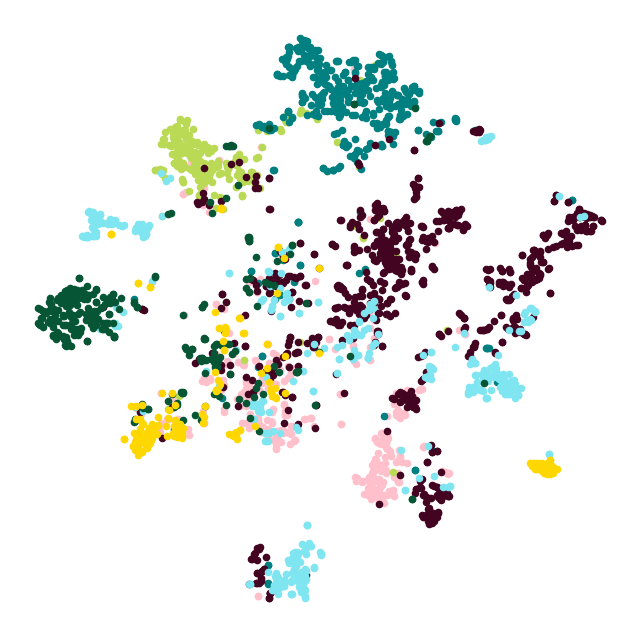

In [17]:
#%%
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)